# RNSA Bone Age

In [1]:
import pandas as pd
import numpy as np

from os import listdir, mkdir, rename, makedirs
from os.path import isfile, join, isdir

from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras import layers, models, regularizers, optimizers
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import Xception
from keras.layers import Flatten, Dense, Dropout
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [2]:
train = pd.read_csv('../rsna-bone-age/boneage-training-dataset.csv', index_col='id')
test = pd.read_csv('../rsna-bone-age/test.csv', index_col='id')

In [3]:
train.shape, test.shape

((12611, 2), (200, 2))

## Descriptives of dataset

In [4]:
train['gender'] = train.apply(lambda row: 'male' if row['male']==True else 'female', axis=1)
test['gender'] = test.apply(lambda row: 'male' if row['male']==True else 'female', axis=1)

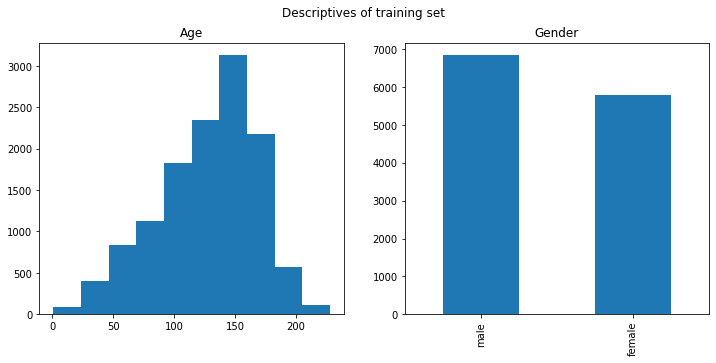

In [5]:
fig = plt.figure(figsize=(12,5)) 
fig_dims = (1, 2)
fig.suptitle('Descriptives of training set')

plt.subplot2grid(fig_dims, (0, 0))
plt.hist(train['boneage'])
plt.title('Age')

plt.subplot2grid(fig_dims, (0, 1))
train['gender'].value_counts().plot(kind='bar', title='Gender');

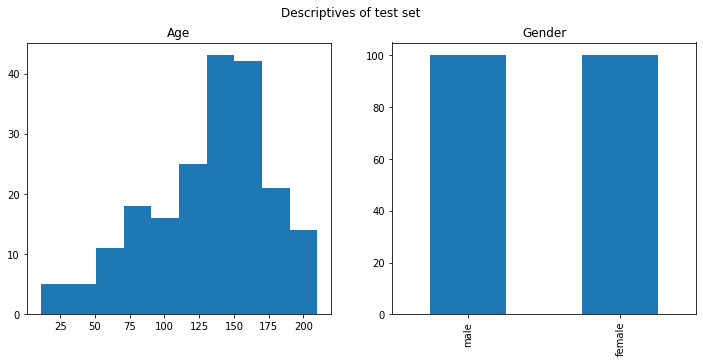

In [6]:
fig = plt.figure(figsize=(12,5)) 
fig_dims = (1, 2)
fig.suptitle('Descriptives of test set')

plt.subplot2grid(fig_dims, (0, 0))
plt.hist(test['boneage'])
plt.title('Age')

plt.subplot2grid(fig_dims, (0, 1))
test['gender'].value_counts().plot(kind='bar', title='Gender');

## Add image path to df

In [7]:
def imgs_path(df, typ):
    """
    Function to add the image path to df
    """
    
    path = '../rsna-bone-age/boneage-{}-dataset/'.format(typ)
    df['img_path'] = None
    for img in listdir(path):
        if img.endswith('.png'):
            img_path = path + img 
            df.loc[(int(img.strip('.png'))), 'img_path'] = img_path
    return df

In [8]:
train = imgs_path(train, 'training')
test = imgs_path(test, 'test')

In [9]:
train.shape, test.shape

((12611, 4), (200, 4))

### Resizing and Padding
Code for the resize and padding function was taken from: https://jdhao.github.io/2017/11/06/resize-image-to-square-with-padding/

In [10]:
import sys
import cv2

def resize_padding_img(img_path, desired_size):
    """
    Function to resize the image with padding
    """
    
    desired_size = desired_size
    im_pth = img_path

    im = cv2.imread(im_pth)
    old_size = im.shape[:2] # old_size is in (height, width) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    im = cv2.resize(im, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return new_im

def resize_padding_set(df, img_set, desired_size, save):
    """
    Function to resize the entire set of images with padding and save to a desired path
    """
    
    # Create directory for resized and padded images
    dirname = '../rsna-bone-age/resized_padded/{}'.format(img_set)
    if save:
        makedirs(dirname)
    
    # Create extra column in df to save path to resized and padded image
    df['rp_img_path'] = None
    
    for index, row in df.iterrows():
        # Resizing and padding
        img_path = row['img_path']
        if save:
            rp_img = resize_padding_img(img_path, desired_size)
        
        # Write resized and padded images to disk
        filename = '{}.jpg'.format(index)
        if save:    
            cv2.imwrite(dirname + '/' + filename, rp_img) 
        
        # Save path to resized and padded image to df
        df.loc[index, 'rp_img_path'] = dirname + '/' + filename
        
    return df

In [11]:
train = resize_padding_set(train, 'training', 100, False)
test = resize_padding_set(test, 'test', 100, False)

In [12]:
train.shape, test.shape

((12611, 5), (200, 5))

In [13]:
from sklearn.metrics import mean_absolute_error

val = train[round(0.8*len(train)):].boneage

y_pred = [val.mean() for x in range(len(val))]
y_true = list(val)

mean_absolute_error(y_true, y_pred)

32.056923969936875

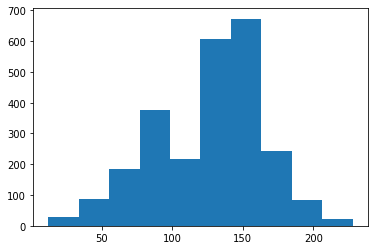

In [14]:
plt.hist(y_true);

### Load Resized and Padded images to memory

In [15]:
def load_images(df):
    """
    Function to load the resized and padded images and corresponding labels to numpy array
    """
    
    X = []
    y = []
    
    for index, row in df.iterrows():
        img_path = row['rp_img_path']
        img = cv2.imread(img_path)
        age = row['boneage']
        X.append(img)
        y.append(age)
    
    # scale the images
    X = np.array(X)/255
    y = np.array(y)
    
    # Shuffle the X and y
    X, y = shuffle(X, y, random_state=2020)
    
    return X, y

In [16]:
X_train, y_train = load_images(train)
X_test, y_test = load_images(test)

In [17]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12611, 100, 100, 3), (12611,), (200, 100, 100, 3), (200,))

### Image Data Generator to prevent memory error

In [18]:
# train_datagen = ImageDataGenerator(rescale=1./255,
#                                   validation_split=0.2)

# test_datagen = ImageDataGenerator(rescale=1./255)

# train_generator = train_datagen.flow_from_dataframe(
#     dataframe=train[:64], 
#     directory='./rsna-bone-age/resized_padded/training',
#     x_col='rp_img_path',
#     y_col='boneage',
#     target_size=(500,500),
#     color_mode='rgb',
#     class_mode='other',
#     batch_size=32,
#     subset='training')

# validation_generator = train_datagen.flow_from_dataframe(
#     dataframe=train[:64], 
#     directory='./rsna-bone-age/resized_padded/training',
#     x_col='rp_img_path',
#     y_col='boneage',
#     target_size=(500,500),
#     color_mode='rgb',
#     class_mode='other',
#     batch_size=32,
#     subset='validation')

# test_generator = test_datagen.flow_from_dataframe(
#     dataframe=test,
#     directory='./rsna-bone-age/resized_padded/test',
#     x_col='rp_img_path',
#     y_col='boneage',
#     target_size=(500,500),
#     color_mode='rgb',
#     class_mode='other',
#     batch_size=200) # All images from test set in one batch

### Plot a few images in the training set

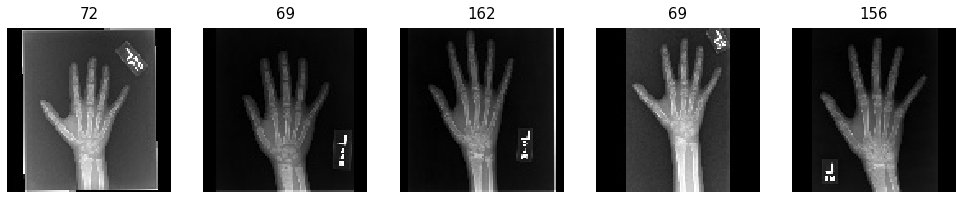

In [19]:
def plot_images(X, y):
    fig, axes = plt.subplots(1, len(X), figsize=(17, 5))
    for idx, ax in enumerate(axes): 
        ax.axis('off')
        ax.imshow(X[idx][:,::-1])
        ax.set_title(y[idx], size=15, pad=10)

plot_images(X_train[10:15], y_train[10:15])

In [20]:
# def plot_images(generator):
#     X, y = next(generator)
#     fig, axes = plt.subplots(1, len(X[15:20]), figsize=(17, 5))
#     for idx, ax in enumerate(axes):
#         ax.axis('off')
#         ax.imshow(X[idx][:,:,::-1])
#         ax.set_title(y[idx], size=15, pad=10)

# plot_images(train_generator)

## Deep Learning
### Initial pre-trained Xception model

In [21]:
# Instantiate Xception model trained on imagenet
pre_trained_model = Xception(weights='imagenet', include_top=False,
                             input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))

# Freeze all layers 
for layer in pre_trained_model.layers: 
    layer.trainable = False

# Add a Global Average Pooling layer to reduce the number of parameters in the model
pooling = layers.GlobalAveragePooling2D()(pre_trained_model.output)
add_layer = pooling

# Add a dense layer after the pre-trained CNN
add_layer = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.1))(add_layer)

# Add output layer for regression
output_layer = Dense(1, activation='linear')(add_layer)

# Build new model structure
model = Model(inputs=pre_trained_model.input, outputs=output_layer)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 49, 49, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 49, 49, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 49, 49, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [22]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_mae', patience=20)

checkpointer = ModelCheckpoint(filepath='./models/keras_weights_{}.hdf5'.format(model.name),
                               monitor='val_mae',
                               save_best_only=True)

callbacks = [early_stopping, checkpointer]

history = model.fit(x=X_train, y=y_train,
                    epochs=100, 
                    validation_split=.25, 
                    verbose=1, 
                    batch_size=64,
                    callbacks=callbacks)

# history = model.fit_generator(train_generator,
#                               epochs=2,
#                               verbose=2,
#                               callbacks=callbacks,
#                               validation_data=validation_generator)

Train on 9458 samples, validate on 3153 samples
Epoch 1/100
9458/9458 [==============================] - 481s 51ms/step - loss: 11714.1469 - mae: 96.1822 - val_loss: 8134.0263 - val_mae: 76.4264
Epoch 2/100
9458/9458 [==============================] - 469s 50ms/step - loss: 9699.0962 - mae: 84.8589 - val_loss: 6485.6310 - val_mae: 66.7862
Epoch 3/100
9458/9458 [==============================] - 461s 49ms/step - loss: 9088.2452 - mae: 81.5654 - val_loss: 5819.2024 - val_mae: 62.6463
Epoch 4/100
9458/9458 [==============================] - 461s 49ms/step - loss: 8373.2784 - mae: 77.8497 - val_loss: 4391.7373 - val_mae: 52.1581
Epoch 5/100
9458/9458 [==============================] - 464s 49ms/step - loss: 7524.7179 - mae: 73.2770 - val_loss: 3791.2913 - val_mae: 46.5292
Epoch 6/100
9458/9458 [==============================] - 479s 51ms/step - loss: 6599.5944 - mae: 67.5520 - val_loss: 4748.2257 - val_mae: 54.2580
Epoch 7/100
9458/9458 [==============================] - 466s 49ms/step - l

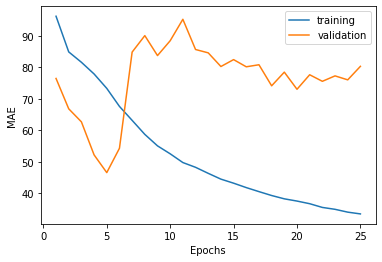

In [23]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(mae)+1)

plt.plot(epochs, mae)
plt.plot(epochs, val_mae)
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend(['training', 'validation'])
plt.show()